## Logistic Regression, Sparsity and L1 Regularization

Colab link: https://colab.research.google.com/notebooks/mlcc/sparsity_and_l1_regularization.ipynb

One way to reduce complexity is to use a regularization function that encourages weights to be exactly zero. For linear models such as regression, a zero weight is equivalent to not using the corresponding feature at all. In addition to avoiding overfitting, the resulting model will be more efficient.

L1 regularization is a good way to increase sparsity.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')

chdf = chdf.reindex(np.random.permutation(chdf.index))

In [0]:
# Preprocessing the features:
def preprocess_features(df):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = df[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]

  # print mean for each pd column:
  # print(selected_features.mean())
  # print(selected_features.std())

  processed_features = selected_features.copy()
  # Create a synthetic feature:
  processed_features['rooms_per_person'] = df['total_rooms'] / df['population']

  # Scaling the features:
  processed_features -= processed_features.mean()
  processed_features /= processed_features.std()

  return processed_features

In [0]:
# Preprocessing the labels:
def preprocess_targets(df):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()  # just to initialise the pd dataframe
  # Scale the target to be in units of thousands of dollars.
  # output_targets['median_house_value'] = df['median_house_value'] / 1000.0
  # Create a boolean categorical feature representing whether the
  # median_house_value is above a set threshold.
  output_targets['median_house_value_is_high'] = df['median_house_value'].apply(lambda val : 1 if val>265000 else 0)
  # alternative:
  # output_targets['median_house_value_is_high'] = (df['median_house_value']>265000).astype(float)  # astype(float) converts the boolean (False, True) to (0, 1)

  return output_targets


In [0]:
def TrainValTestDataSplit(feat_df, targ_df, train_percentage, val_percentage, test_percentage):

  # Data reshuffled randomly, just in case it hasn't been done yet:
  my_index = np.random.permutation(feat_df.index)
  feat_df = feat_df.reindex(my_index)
  targ_df = targ_df.reindex(my_index)

  # Training, Validation and Test dataset sizes:
  m_train = int(train_percentage*feat_df.shape[0])
  m_test = int(test_percentage*feat_df.shape[0])
  m_val = feat_df.shape[0] - m_train - m_test


  # Splitting DF into training and validation sets:
  training_examples = feat_df.head(m_train)
  training_targets = targ_df.head(m_train)
 
  validation_examples = feat_df.iloc[m_train:m_train+m_val] 
  validation_targets = targ_df.iloc[m_train:m_train+m_val]

  test_examples = feat_df.tail(m_test)  # we take the last examples using the tail command
  test_targets = targ_df.tail(m_test)

  return training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets


In [0]:
# Loading the data:
chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')
chdf = chdf.reindex(np.random.permutation(chdf.index))


# Processing the data:
pchdf = preprocess_features(chdf)  # def preprocess_features
ochdf = preprocess_targets(chdf)

print(pchdf.head())
print(ochdf.head())


# Chosen features:
# chosen_features = ['households', 'longitude', 'latitude', 'housing_median_age', 'median_income', 'rooms_per_person']
# pchdf = pchdf[chosen_features]


# Binning 'Latitude' feature:   # bucketised in feature columns
# pchdf = BinFeature(pchdf, 'latitude', [-2, 3])   # def BinFeature

# display.display(pchdf.head())


# Splitting the dataframe (total must sum 1!!!):
train_percentage = 0.75
val_percentage = 0.25
test_percentage = 0.0

[training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets] = TrainValTestDataSplit(pchdf, ochdf, train_percentage, val_percentage, test_percentage)  # def TrainValTestDataSplit


# Describing the different data sets:
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Test examples summary:")
display.display(test_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())

       latitude  longitude  ...  median_income  rooms_per_person
2377       -0.7        1.0  ...           -0.0              -0.3
10564      -0.3       -0.4  ...           -0.1              -0.5
7070       -0.7        0.6  ...           -1.0              -1.1
5497       -0.9        0.7  ...           -1.0              -0.8
2301       -0.8        1.1  ...           -0.4              -0.3

[5 rows x 9 columns]
       median_house_value_is_high
2377                            0
10564                           0
7070                            0
5497                            0
2301                            0
Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0
mean,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.4,-2.4,-2.2,-1.2,-1.3,-1.2,-1.3,-1.8,-1.7
25%,-0.8,-1.1,-0.8,-0.5,-0.6,-0.6,-0.6,-0.7,-0.4
50%,-0.6,0.5,0.0,-0.2,-0.2,-0.2,-0.2,-0.2,-0.0
75%,1.0,0.8,0.7,0.2,0.3,0.3,0.3,0.5,0.3
max,3.0,2.6,1.9,16.2,14.0,29.8,14.5,5.8,45.5


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,4250.0,4250.0,4250.0,4250.0,4250.0,4250.0,4250.0,4250.0,4250.0
mean,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,0.9,1.0,1.0,0.9
min,-1.4,-2.4,-2.1,-1.2,-1.3,-1.2,-1.3,-1.8,-1.6
25%,-0.8,-1.1,-0.8,-0.5,-0.6,-0.6,-0.6,-0.7,-0.4
50%,-0.6,0.5,-0.0,-0.2,-0.3,-0.2,-0.2,-0.2,-0.0
75%,1.0,0.8,0.7,0.2,0.3,0.2,0.3,0.4,0.3
max,3.0,2.5,1.9,13.5,11.3,12.3,11.8,5.8,21.5


Test examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,nan,nan,nan,nan,nan,nan,nan,nan,nan
std,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,nan,nan,nan,nan,nan,nan,nan,nan,nan
25%,nan,nan,nan,nan,nan,nan,nan,nan,nan
50%,nan,nan,nan,nan,nan,nan,nan,nan,nan
75%,nan,nan,nan,nan,nan,nan,nan,nan,nan
max,nan,nan,nan,nan,nan,nan,nan,nan,nan


Training targets summary:


,median_house_value_is_high
count,12750.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,4250.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Test targets summary:


,median_house_value_is_high
count,0.0
mean,nan
std,nan
min,nan
25%,nan
50%,nan
75%,nan
max,nan


In [0]:
# Input function:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()  ## TF 1!!!

    return features, labels


In [0]:
def get_quantile_based_buckets(feature_values, num_buckets):
  quantiles = feature_values.quantile(
    [(i+1.)/(num_buckets + 1.) for i in range(num_buckets)])
  return [quantiles[q] for q in quantiles.keys()]

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """

  bucketized_households = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("households"),
    boundaries=get_quantile_based_buckets(training_examples["households"], 10))
  bucketized_longitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("longitude"),
    boundaries=get_quantile_based_buckets(training_examples["longitude"], 50))
  bucketized_latitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("latitude"),
    boundaries=get_quantile_based_buckets(training_examples["latitude"], 50))
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("housing_median_age"),
    boundaries=get_quantile_based_buckets(
      training_examples["housing_median_age"], 10))
  bucketized_total_rooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_rooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_rooms"], 10))
  bucketized_total_bedrooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_bedrooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_bedrooms"], 10))
  bucketized_population = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("population"),
    boundaries=get_quantile_based_buckets(training_examples["population"], 10))
  bucketized_median_income = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("median_income"),
    boundaries=get_quantile_based_buckets(training_examples["median_income"], 10))
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("rooms_per_person"),
    boundaries=get_quantile_based_buckets(
      training_examples["rooms_per_person"], 10))

  long_x_lat = tf.feature_column.crossed_column(
    set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

  feature_columns = set([
    long_x_lat,
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_total_rooms,
    bucketized_total_bedrooms,
    bucketized_population,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

# Calculate the model size

Model size is the number of parameters used in the regression.
To reduce the number of paramters, L1 regularisatin can be used.

This is how to calculate the model size:

In [0]:
def model_size(estimator):
  variables = estimator.get_variable_names()
  size = 0
  for variable in variables:
    if not any(x in variable 
               for x in ['global_step',
                         'centered_bias_weight',
                         'bias_weight',
                         'Ftrl']
              ):
      size += np.count_nonzero(estimator.get_variable_value(variable))
  return size

### Task 1: Find a good regularization coefficient.

**Find an L1 regularization strength parameter which satisfies both constraints — model size is less than 600 and log-loss is less than 0.35 on validation set.**

The following code will help you get started. There are many ways to apply regularization to your model. Here, we chose to do it using `FtrlOptimizer`, which is designed to give better results with L1 regularization than standard gradient descent.

Again, the model will train on the entire data set, so expect it to run slower than normal.

In [0]:
def train_linear_classifier_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    regularization_strength: A `float` that indicates the strength of the L1
       regularization. A value of `0.0` means no regularization.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 7
  steps_per_period = steps / periods

  # Create a linear classifier object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value_is_high"], batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value_is_high"], batch_size=1, num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value_is_high"], batch_size=1, num_epochs=1, shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on validation data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    # Compute training and validation loss.
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()
  plt.grid()

  print(training_probabilities.shape)
  # Get the predictions using the probabilities: if prob>=0.5 -> y_pre=1; if prb<0.5 -> y_pred=0
  training_predictions = np.array( list( map(lambda val : 1 if val>0.5 else 0, training_probabilities[:,1]) ) )   # if prob>0.5 -> 1; if prob<0.5 ->  0    # to get more than one column: training_probabilities[:,[0:5]]
  validation_predictions = np.array( list( map(lambda val : 1 if val>0.5 else 0, validation_probabilities[:,1]) ) )   # if prob>0.5 -> 1; if prob<0.5 ->  0

  plt.subplot(1,2,2)
  plt.plot(training_predictions, training_targets.values, '.', label='training predicted vs reality' )
  plt.plot(validation_predictions, validation_targets.values, '.', label='validation predicted vs reality')
  plt.legend()
  plt.grid()
  plt.ylabel("targets")
  plt.xlabel("predictions")
  plt.title("Predicted vs Targets")
  plt.show()

  return linear_classifier

Training model...
LogLoss (on validation data):
  period 00 : 0.31
  period 01 : 0.27
  period 02 : 0.24
  period 03 : 0.24
  period 04 : 0.23
  period 05 : 0.23
  period 06 : 0.23
Model training finished.
(12750, 2)


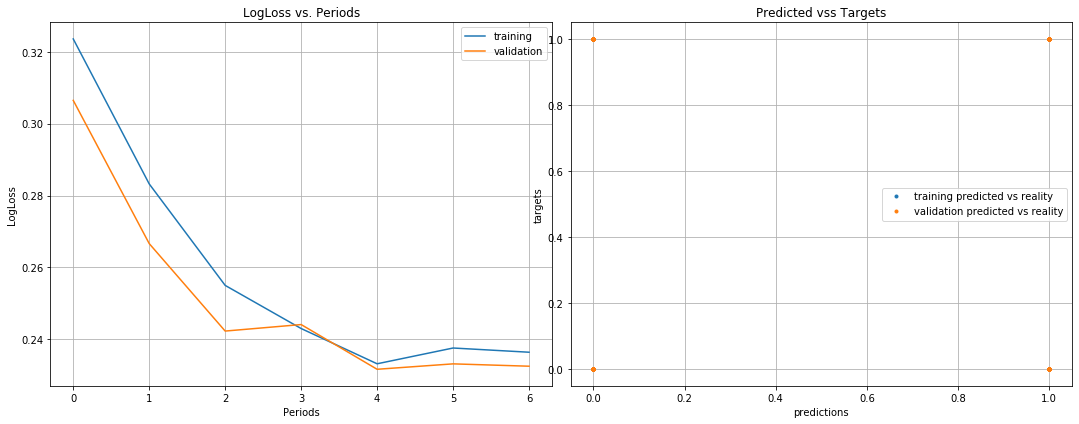

Linear Classification with L1 regularisation. Model Size: 445.000


In [0]:
# Call the training model:
learning_rate = 1.0
steps = 600
batch_size = 20
regularization_strength = 0.8


linear_classification = train_linear_classifier_model(
    learning_rate=learning_rate,
    regularization_strength = regularization_strength,
    steps=steps,
    batch_size=batch_size,
    feature_columns = construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)


# Calculating Model Size:
print( 'Linear Classification with L1 regularisation. Model Size: %0.3f' %(model_size(linear_classification)) )